In [2]:
!pip install pandas
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.models import efficientnet_b0
from sklearn.model_selection import train_test_split
import pandas as pd
import os
from PIL import Image
from torch.utils.data import Dataset



   ---------------------------------------- 0.0/11.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.6 MB ? eta -:--:--
    --------------------------------------- 0.3/11.6 MB ? eta -:--:--
    --------------------------------------- 0.3/11.6 MB ? eta -:--:--
    --------------------------------------- 0.3/11.6 MB ? eta -:--:--
   - -------------------------------------- 0.5/11.6 MB 453.5 kB/s eta 0:00:25
   - -------------------------------------- 0.5/11.6 MB 453.5 kB/s eta 0:00:25
   - -------------------------------------- 0.5/11.6 MB 453.5 kB/s eta 0:00:25
   -- ------------------------------------- 0.8/11.6 MB 419.4 kB/s eta 0:00:26
   -- ------------------------------------- 0.8/11.6 MB 419.4 kB/s eta 0:00:26
   -- ------------------------------------- 0.8/11.6 MB 419.4 kB/s eta 0:00:26
   --- -----------------------------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.14 requires torch<2.3,>=1.10, but you have torch 2.5.0 which is incompatible.
label-studio 1.12.1 requires Django<3.3.0,>=3.2.24, but you have django 5.1.2 which is incompatible.
label-studio 1.12.1 requires numpy<2.0.0,>=1.24.3, but you have numpy 2.1.2 which is incompatible.
label-studio 1.12.1 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
ultralytics 8.2.57 requires numpy<2.0.0,>=1.23.0, but you have numpy 2.1.2 which is incompatible.


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [7]:
# Define parameters
DATA_DIR = '/home/iambrink/Clothing_AI_Model/Clothing_AI_Model/Clothing_Data/images_compressed'
CSV_FILE = '/home/iambrink/Clothing_AI_Model/Clothing_AI_Model/Clothing_Data/filtered_images.csv'
MODEL_PATH = 'Clothing_AI_Model_V2.pt'
NUM_CLASSES = 14  # Adjust based on your labels
BATCH_SIZE = 64
EPOCHS = 100
LEARNING_RATE = 0.0001


In [8]:
# Load dataset
df = pd.read_csv(CSV_FILE)

# Split data into train, validation, and test sets
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.33, random_state=42, stratify=temp_df['label'])


In [9]:
import pandas as pd
import torch
from torch.utils.data import Dataset
from PIL import Image
import os

class CustomImageDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.class_names = self.data_frame['label'].unique()  # Get unique class names
        # Create a mapping of labels to integers
        self.label_mapping = {label: idx for idx, label in enumerate(sorted(self.data_frame['label'].unique()))}
        
    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.data_frame.iloc[idx, 0].strip() + '.jpg')  # Add .jpg extension
        image = Image.open(img_name).convert("RGB")  # Open image and convert to RGB
        
        # Get the label and convert it to an integer tensor
        label_str = self.data_frame.iloc[idx, 2]  # Get the label as a string
        label = self.label_mapping[label_str]  # Map the string to an integer
        label_tensor = torch.tensor(label, dtype=torch.long)  # Convert to tensor

        if self.transform:
            image = self.transform(image)

        return image, label_tensor  # Return the image and the tensor label


In [10]:

import torchvision.transforms as transforms

# Define any transformations you want to apply
transform = transforms.ToTensor()  # Converts PIL image to tensor

dataset = CustomImageDataset(CSV_FILE, '/home/iambrink/Clothing_AI_Model/Clothing_AI_Model/Clothing_Data/images_compressed/', transform=transform)
for i in range(5):  # Check the first 5 entries
    image, label = dataset[i]
    print(f'Image shape: {image.shape}, Label: {label}')


Image shape: torch.Size([3, 533, 400]), Label: 1
Image shape: torch.Size([3, 533, 400]), Label: 12
Image shape: torch.Size([3, 533, 400]), Label: 7
Image shape: torch.Size([3, 533, 400]), Label: 4
Image shape: torch.Size([3, 533, 400]), Label: 7


In [11]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset

# Load your full dataset
full_dataset = CustomImageDataset(CSV_FILE, DATA_DIR, transform=transform)

# Get the number of samples
num_samples = len(full_dataset)

# Step 1: Split into training + validation and test sets (80% train+val, 20% test)
train_val_indices, test_indices = train_test_split(
    range(num_samples), 
    test_size=0.1,  # 10% for testing
    stratify=full_dataset.data_frame['label']  # stratify if class imbalance
)

# Step 2: Split training + validation into training and validation sets (70% train, 30% val of the remaining 80%)
train_indices, val_indices = train_test_split(
    train_val_indices, 
    test_size=0.25,  # 25% of 80% -> 20% of total
    stratify=[full_dataset.data_frame['label'][i] for i in train_val_indices]  # stratify using original labels
)

# Create subsets for each split
train_subset = Subset(full_dataset, train_indices)
val_subset = Subset(full_dataset, val_indices)
test_subset = Subset(full_dataset, test_indices)

# Step 3: Create data loaders
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False)

# Print sizes to verify splits
print(f'Train set size: {len(train_subset)}')
print(f'Validation set size: {len(val_subset)}')
print(f'Test set size: {len(test_subset)}')


Train set size: 3184
Validation set size: 1062
Test set size: 472


In [13]:
# Define the model
model = efficientnet_b0(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, NUM_CLASSES)  # Adjust output layer for the number of classes


/home/iambrink/miniconda3/envs/tf-gpu/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/iambrink/miniconda3/envs/tf-gpu/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


In [10]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1)


In [ ]:
from tqdm import tqdm

best_val_accuracy = 0.0

for epoch in range(EPOCHS):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    # Training Loop with tqdm for progress bar
    for images, labels in tqdm(train_loader, desc=f'Training Epoch {epoch + 1}/{EPOCHS}'):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()  # Zero the gradients

        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update the model parameters

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total

    # Validation Loop
    model.eval()  # Set model to evaluation mode
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():  # No gradient calculation during validation
        for images, labels in tqdm(val_loader, desc='Validating'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss = criterion(outputs, labels)
            val_running_loss += val_loss.item()

            # Calculate validation accuracy
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(val_loader)
    val_accuracy = val_correct / val_total

    print(f'\tEpoch: {epoch + 1} \tTrain Loss: {train_loss:.4f} \tTrain Acc: {train_accuracy:.4f} \tVal Loss: {val_loss:.4f} \tVal Acc: {val_accuracy:.4f}') 

    # Scheduler step for ReduceLROnPlateau (based on validation loss)
    scheduler.step(val_loss)

    # Save the best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), MODEL_PATH)
        print(f"New best validation accuracy: {best_val_accuracy:.4f}")

print(f'Best Validation Accuracy: {best_val_accuracy:.4f}')


In [14]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt

Test Accuracy: 0.9216
Testing AUC: 0.9924
Test Precision: 0.9218
Test Recall: 0.9216
Test F1 Score: 0.9207

Classification Report:
                  precision    recall  f1-score   support

            Body       0.80      0.73      0.76        11
         T-Shirt       0.86      0.86      0.86         7
           Pants       0.91      0.82      0.86        38
             Hat       0.94      0.92      0.93        36
           Dress       1.00      0.94      0.97        17
      Undershirt       0.82      0.90      0.86        10
      Longsleeve       0.90      0.90      0.90        70
           Shoes       0.94      0.97      0.96        69
            Polo       0.90      0.75      0.82        12
          Shorts       1.00      0.98      0.99        43
           Skirt       0.91      0.94      0.92        31
Buttondown_Shirt       0.88      0.93      0.90        15
          Blazer       0.92      0.98      0.95       101
          Hoodie       0.90      0.75      0.82        1

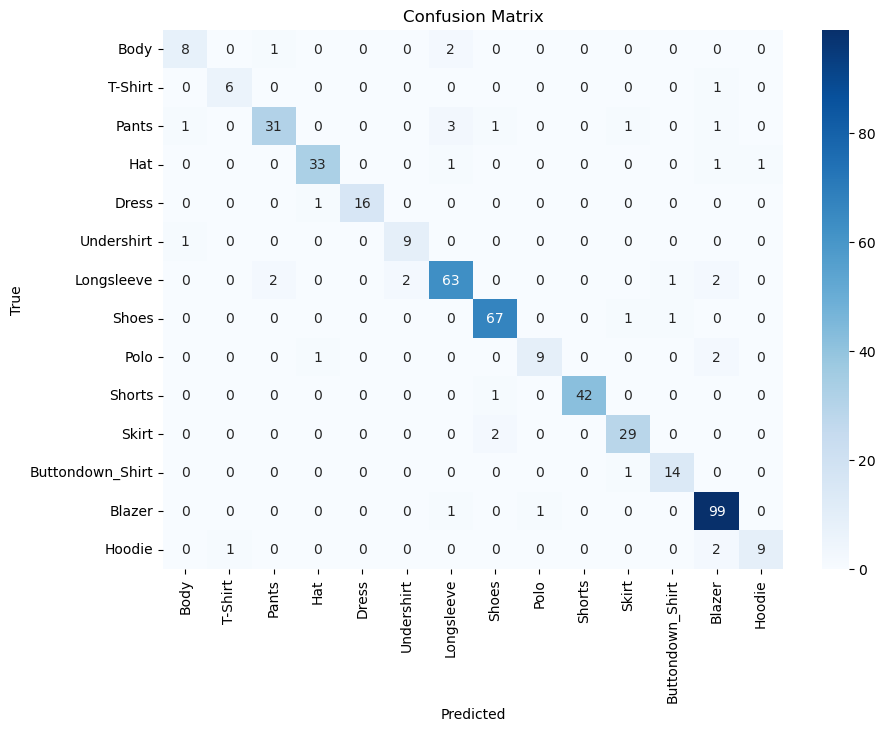

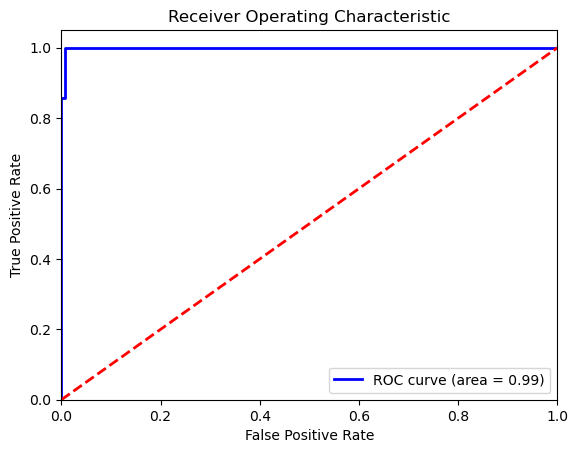

In [17]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, classification_report, 
                             roc_curve, roc_auc_score, precision_recall_fscore_support)

# Initialize dataset
dataset = CustomImageDataset(CSV_FILE, '/home/iambrink/Clothing_AI_Model/Clothing_AI_Model/Clothing_Data/images_compressed/')
class_names = dataset.class_names  # Extract class names

# Evaluate on test data
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()
correct = 0
total = 0
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        # Get probabilities instead of predictions
        probabilities = torch.softmax(outputs, dim=1)
        all_probs.append(probabilities.cpu().numpy())
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.append(labels.cpu().numpy())

# Convert to numpy arrays
all_labels = np.concatenate(all_labels)
all_probs = np.concatenate(all_probs)

# Calculate metrics
test_accuracy = correct / total
testing_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')  # AUC for multi-class
conf_matrix = confusion_matrix(all_labels, np.argmax(all_probs, axis=1))
class_report = classification_report(all_labels, np.argmax(all_probs, axis=1), target_names=class_names, output_dict=True)  # Use extracted class names

# Calculate overall precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, np.argmax(all_probs, axis=1), average='weighted')

# Print results
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Testing AUC: {testing_auc:.4f}')
print(f'Test Precision: {precision:.4f}')
print(f'Test Recall: {recall:.4f}')
print(f'Test F1 Score: {f1:.4f}')

# Print classification report
print("\nClassification Report:")
print(classification_report(all_labels, np.argmax(all_probs, axis=1), target_names=class_names))

# Function to plot confusion matrix
def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(conf_matrix, class_names)

# Plot ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_probs[:, 1], pos_label=1)  # Adjust pos_label based on your positive class if needed
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % testing_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# Test


In [13]:
# Assuming the correct label order is found from dataset.class_names
labels = ["Body", "T-Shirt", "Pants", "Hat", "Dress", "Undershirt", 
          "Longsleeve", "Shoes", "Polo", "Shorts", "Skirt", 
          "Buttondown_Shirt", "Blazer", "Hoodie"]


In [62]:
Official_Testing_labels = ['blazer','body','buttondown-shirt','dress','hat','hoodie','longsleve','pants','polo-shirt','shoes','shorts','skirt','T-shirt','under-shirt']

Predicted class index: 1, Label: body


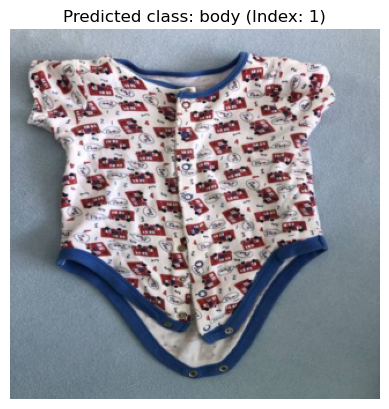

In [63]:
import torch
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np

# Define transformations
transform = transforms.Compose([
    transforms.Resize((320, 320)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# Load your dataset
dataset = CustomImageDataset(csv_file=CSV_FILE, img_dir=DATA_DIR, transform=transform)

# Load the specific model architecture used during training
model = models.efficientnet_b0(num_classes=len(Official_Testing_labels))  # Specify the number of classes using Official_labels
model.load_state_dict(torch.load('/home/iambrink/Clothing_AI_Model/Clothing_AI_Model.pt'))
model.eval()

# Make predictions on an image from the dataset
image, _ = dataset[0]  # Load the first image
image_tensor = image.unsqueeze(0)  # Add batch dimension

with torch.no_grad():
    output = model(image_tensor)

predicted_probabilities = torch.softmax(output, dim=1)
predicted_class_idx = predicted_probabilities.argmax(dim=1).item()

# Retrieve the predicted class label from Official_labels
predicted_label = Official_Testing_labels[predicted_class_idx]

# Print predicted class index and label
print(f'Predicted class index: {predicted_class_idx}, Label: {predicted_label}')

# Convert the image tensor back to a NumPy array for display
image_np = image.permute(1, 2, 0).numpy()  # Change dimensions from CxHxW to HxWxC
image_np = (image_np * 0.5) + 0.5  # Unnormalize the image (assuming normalization was done with mean=0.5, std=0.5)
image_np = np.clip(image_np, 0, 1)  # Ensure values are between 0 and 1

# Display the image
plt.imshow(image_np)
plt.title(f'Predicted class: {predicted_label} (Index: {predicted_class_idx})')
plt.axis('off')  # Turn off axis labels
plt.show()
